Con finetunning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 22 images belonging to 3 classes.
Found 4 images belonging to 3 classes.
Clases asignadas: {'dry': 0, 'mixed': 1, 'oily': 2}


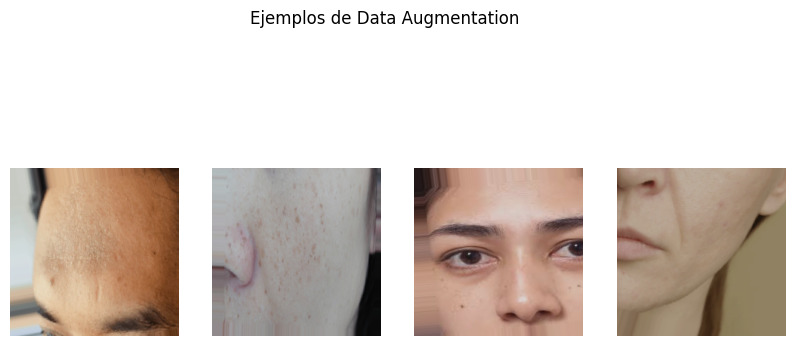

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.0550 - loss: 2.4325

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.0708 - loss: 2.4123 - val_accuracy: 0.5000 - val_loss: 1.9713
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.0000e+00 - loss: 2.7531 - val_accuracy: 0.5000 - val_loss: 1.9431
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step - accuracy: 0.5201 - loss: 1.9047 - val_accuracy: 0.5000 - val_loss: 1.8091
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.2500 - loss: 2.2620 - val_accuracy: 0.5000 - val_loss: 1.7597
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.5888 - loss: 1.8458 - val_accuracy: 0.5000 - val_loss: 1.6111
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.7500 - loss: 1.7679 - val_accuracy: 0.5000 - val_loss: 1.5878
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.5444 - loss: 1.7029 - val_accuracy: 0.5000 - val_loss: 1.5148
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7500 - loss: 1.4059 - val_accuracy: 0.5000 - val_loss: 1.5016
E

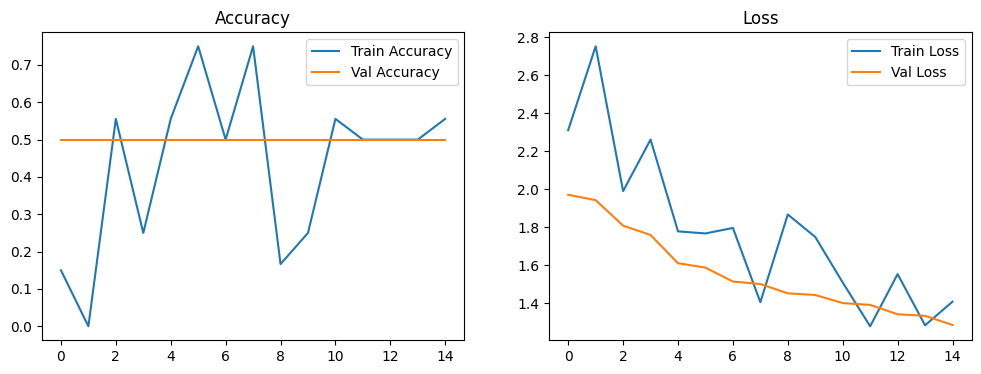

¡Entrenamiento completado!


In [ ]:

!pip install tensorflow


# ======================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ======================
# 2. Parámetros clave
# ======================
DATA_DIR = '/content/drive/Shareddrives/Desarrollo/scrape/data'  # Ajustar ruta
IMG_SIZE = (224, 224)  # Tamaño para EfficientNet
BATCH_SIZE = 4  # Batch pequeño por tener pocos datos
EPOCHS = 15  # Épocas (usaremos EarlyStopping)
NUM_CLASSES = 3  # Grasa, Seca, Mixta

# ======================
# 3. Data Augmentation AGRESIVO (para 12 imágenes)
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,  # Corte leve (cuidado con exceso)
    zoom_range=0.2,
    brightness_range=[0.7, 1],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split=0.2  # 20% para validación
)

# Generadores de datos
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Verificar clases
print("Clases asignadas:", train_generator.class_indices)

# Visualizar augmentation (opcional)
images, _ = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle('Ejemplos de Data Augmentation')
plt.show()

# ======================
# 4. Modelo con Transfer Learning
# ======================
# Cargar EfficientNet pre-entrenada
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # Congelar inicialmente

# Arquitectura personalizada
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.6),  # Dropout alto para evitar overfitting
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilación
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/Shareddrives/Desarrollo/scrape/best_model.h5',
    save_best_only=True,
    monitor='val_accuracy'
)

# ======================
# 5. Entrenamiento
# ======================
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# ======================
# 6. Evaluación y Guardado Final
# ======================
# Guardar modelo final
model.save('/content/drive/Shareddrives/Desarrollo/scrape/final_model.h5')

# Gráficas de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

print("¡Entrenamiento completado!")

mixed como clase residual


In [ ]:
# -*- coding: utf-8 -*-
"""Genera 10 imágenes aumentadas por cada original y entrena EfficientNetB0."""
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import os
import numpy as np
from PIL import Image

# ======================
# 1. Configuración inicial
# ======================
DATA_DIR = '/content/drive/Shareddrives/Desarrollo/scrape/data'  # Carpeta con dry/ y oily/
AUGMENTED_DIR = '/content/drive/Shareddrives/Desarrollo/scrape/aug'  # Nueva carpeta para imágenes aumentadas
IMG_SIZE = (224, 224)
NUM_AUGMENTED_PER_IMAGE = 10  # 10 imágenes nuevas por cada original

# Crear carpeta para imágenes aumentadas (si no existe)
os.makedirs(AUGMENTED_DIR, exist_ok=True)
for class_name in ['dry', 'oily']:
    os.makedirs(os.path.join(AUGMENTED_DIR, class_name), exist_ok=True)

# ======================
# 2. Data Augmentation OFFLINE (Genera imágenes nuevas)
# ======================
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generar imágenes aumentadas y guardarlas
for class_name in ['dry', 'oily']:
    class_dir = os.path.join(DATA_DIR, class_name)
    augmented_class_dir = os.path.join(AUGMENTED_DIR, class_name)

    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        try:
            img = Image.open(img_path)
            # Convertir a RGB si es necesario (maneja RGBA)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            img = img.resize(IMG_SIZE)
            img_array = np.array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión batch (1, 224, 224, 3)

            # Generar 10 variaciones
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_class_dir,
                                     save_prefix=f'aug_{os.path.splitext(filename)[0]}', # Usar nombre original para prefijo
                                     save_format='jpg'):
                i += 1
                if i >= NUM_AUGMENTED_PER_IMAGE:
                    break
        except Exception as e:
            print(f"Error procesando {filename}: {e}")


print("¡Imágenes aumentadas generadas en:", AUGMENTED_DIR)

In [ ]:
from tensorflow.keras import regularizers

# A. Reinicialización completa del modelo
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)  # Asegurar 3 canales
)
base_model.trainable = False  # Congelar inicialmente

# B. Arquitectura más robusta
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu',
                        kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='softmax')
])

# C. Optimización cuidadosa
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Learning rate más alto inicial
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ======================
# 3. ENTRENAMIENTO CON MONITOREO
# ======================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30,
    callbacks=[early_stop],
    class_weight={0: 1.2, 1: 0.8}  # Ajustar según distribución real
)


# ======================
# 5. Clasificación con Mixed Residual (Versión Mejorada)
# ======================
def predict_skin_type(image_path, model, dry_oily_threshold=0.7, mixed_threshold=0.4):
    """
    Versión mejorada que:
    1. Clasifica dry/oily si confianza > dry_oily_threshold
    2. Clasifica mixed si:
       - La confianza máxima < mixed_threshold O
       - La diferencia entre las dos probabilidades es pequeña
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    preds = model.predict(np.expand_dims(img_array, axis=0))[0]

    max_prob = max(preds)
    diff = abs(preds[0] - preds[1])

    if max_prob < dry_oily_threshold or diff < 0.3:  # Umbrales ajustables
        return "mixed"
    else:
        return ['dry', 'oily'][np.argmax(preds)]

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 738ms/step - accuracy: 0.5277 - loss: 2.1779 - val_accuracy: 0.5200 - val_loss: 1.8977
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 633ms/step - accuracy: 0.4508 - loss: 2.2665 - val_accuracy: 0.5200 - val_loss: 1.8677
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 633ms/step - accuracy: 0.4870 - loss: 2.0746 - val_accuracy: 0.5200 - val_loss: 1.8476
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 633ms/step - accuracy: 0.4744 - loss: 2.0554 - val_accuracy: 0.4800 - val_loss: 1.8305
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 656ms/step - accuracy: 0.4701 - loss: 2.0302 - val_accuracy: 0.4800 - val_loss: 1.8224
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 627ms/step - accuracy: 0.5499 - loss: 1.8902 - val_accuracy: 0.4800 - val_loss: 1.8066
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.4885 - loss: 1.8978

KeyboardInterrupt: 

In [ ]:
def predict_skin_type(model, image_path, threshold=0.5): # Add model as argument
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    preds = model.predict(np.expand_dims(img_array, axis=0))[0]
    print("preds: ", preds)
    return "mixed" if max(preds) < threshold else ['dry', 'oily'][np.argmax(preds)]

In [ ]:
def predict_skin_type(image_path, model, dry_oily_threshold=0.5, mixed_threshold=0.4):
    """
    Versión mejorada que:
    1. Clasifica dry/oily si confianza > dry_oily_threshold
    2. Clasifica mixed si:
       - La confianza máxima < mixed_threshold O
       - La diferencia entre las dos probabilidades es pequeña
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    preds = model.predict(np.expand_dims(img_array, axis=0))[0]
    print(preds)
    max_prob = max(preds)
    diff = abs(preds[0] - preds[1])

    if max_prob < dry_oily_threshold or diff < 0.3:  # Umbrales ajustables
        return "mixed"
    else:
        return ['dry', 'oily'][np.argmax(preds)]

Batch shape: (8, 224, 224, 3)
Etiquetas reales: [[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


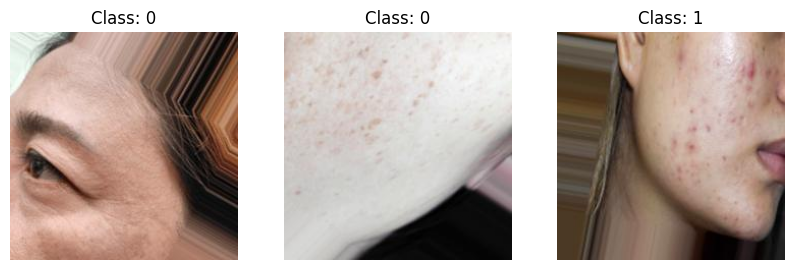

In [ ]:
import matplotlib.pyplot as plt

# Verifica que el generador esté leyendo correctamente las clases
for images, labels in train_generator:
    print("Batch shape:", images.shape)
    print("Etiquetas reales:", labels)
    plt.figure(figsize=(10,5))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(images[i])
        plt.title(f"Class: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break  # Solo mostrar el primer batch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Ensure this is imported
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
from google.colab import drive
# ======================
# 1. Arquitectura Customizada
# ======================
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=2):  # 2 clases (dry/oily)
    model = models.Sequential([
        # Bloque 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Bloque 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Bloque 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Clasificación
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation='softmax')  # 2 neuronas para dry/oily
    ])
    return model

model = build_custom_cnn()

# ======================
# 2. Compilación con Ajustes Críticos
# ======================
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # LR más bajo que lo usual
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# 2. Configuración de rutas
original_dir = '/content/drive/Shareddrives/Desarrollo/scrape/data'  # Carpeta con dry/ y oily/
augmented_dir = '/content/drive/Shareddrives/Desarrollo/scrape/augmented_data'  # Nueva carpeta para aumentadas
os.makedirs(augmented_dir, exist_ok=True)

# 3. Configuración de Data Augmentation (más agresivo)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.4,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

# 4. Función para guardar imágenes aumentadas
def augment_and_save(image_path, output_dir, num_augmented=10):
    img = load_img(image_path)
    x = img_to_array(img)  # Convertir a array (224, 224, 3)
    x = x.reshape((1,) + x.shape)  # Añadir dimensión batch (1, 224, 224, 3)

    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir,
                            save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= num_augmented:
            break

# 5. Generar imágenes aumentadas para cada clase
for class_name in ['dry', 'oily']:
    class_dir = os.path.join(original_dir, class_name)
    augmented_class_dir = os.path.join(augmented_dir, class_name)
    os.makedirs(augmented_class_dir, exist_ok=True)

    print(f"Procesando clase: {class_name}")
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        augment_and_save(img_path, augmented_class_dir, num_augmented=10)

    print(f"¡Generadas {10*len(os.listdir(class_dir))} imágenes para {class_name}!")

print("✅ Generación offline completada. Imágenes guardadas en:", augmented_dir)

# 6. Verificación visual
print("\nEjemplo de imágenes aumentadas:")
sample_img = os.path.join(augmented_dir, 'dry', os.listdir(os.path.join(augmented_dir, 'dry'))[0])
Image.open(sample_img)



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 1. Generadores de datos (ahora con imágenes aumentadas)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    augmented_dir,  # ¡Usar la carpeta con imágenes aumentadas!
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)

# 2. Modelo simple para prueba
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10
)

Procesando clase: dry
¡Generadas 120 imágenes para dry!
Procesando clase: oily
¡Generadas 130 imágenes para oily!
✅ Generación offline completada. Imágenes guardadas en: /content/drive/Shareddrives/Desarrollo/scrape/augmented_data

Ejemplo de imágenes aumentadas:
Found 197 images belonging to 2 classes.
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.4957 - loss: 11.4435
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.7072 - loss: 0.6410
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.8429 - loss: 0.4337
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.9352 - loss: 0.2881
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9325 - loss: 0.2549
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.9485 - loss: 0.1526
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9645 - loss: 0.1177
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - accuracy: 0.9309 - loss: 0.1593
Epo

In [ ]:
import tensorflow as tf
import numpy as np
def predict_skin_type_custom(model, image_path, threshold=0.55):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    preds = model.predict(np.expand_dims(img_array, axis=0))[0]
    print(preds)
    if max(preds) < threshold:  # Si la confianza es baja
        return "mixed"
    else:
        return ['dry', 'oily'][np.argmax(preds)]

In [ ]:
# Guardar en formato HDF5 (.h5)
model.save('/content/drive/Shareddrives/Desarrollo/scrape/bestmodel.h5')

In [ ]:
import joblib

# Guardar modelo
joblib.dump(model, '/content/drive/Shareddrives/Desarrollo/scrape/modelo/model.pkl')

['/content/drive/Shareddrives/Desarrollo/scrape/modelo/model.pkl']

In [ ]:

image_path1 = '/content/drive/Shareddrives/Desarrollo/scrape/data/test/t8.jpeg'
print("Predicción:", predict_skin_type_custom(model_cargado ,image_path1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[0.6544723  0.34552777]
Predicción: dry


In [ ]:
from google.colab import drive
import joblib
drive.mount('/content/drive')
model_cargado = joblib.load('/content/drive/Shareddrives/Desarrollo/scrape/modelo/model.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Distribución de labels en batch: [3. 5.]


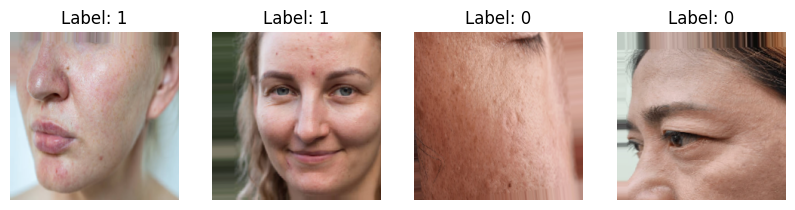

In [ ]:
# ======================
# 1. VERIFICACIÓN CRÍTICA DE DATOS
# ======================
import matplotlib.pyplot as plt
import numpy as np

# Verifica las primeras imágenes y etiquetas
images, labels = next(train_generator)
print("Distribución de labels en batch:", np.sum(labels, axis=0))  # Debe ser ~[4,4] para batch_size=8

# Muestra imágenes con sus etiquetas reales
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis('off')
plt.show()

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

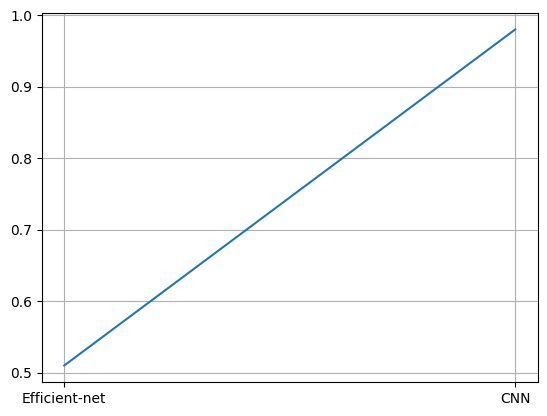

In [12]:
#metricas ef cnn
acccuracy = [0.51, 0.98]
modelo = ["Efficient-net", "CNN"]
loss = [1.28, 0.04]
sns.lineplot(x=modelo, y=acccuracy)
plt.grid(True)
#sns.lineplot(x=['accuracy', 'loss'], y=loss)